In [25]:
#|default_exp training

In [26]:
import sys; sys.path.append('/notebooks')

In [33]:
#| export
from pathlib import Path
import pickle, gzip, math, os, time, shutil, torch
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, nn
import torch.nn.functional as F
from fastcore.foundation import L
from tqdm.auto import tqdm, trange

In [34]:
from fastcore.test import test_close
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
plt.style.use('fast')

In [5]:
path_data = Path('./data')
list(path_data.iterdir())

[PosixPath('../data/mnist.pkl.gz'), PosixPath('../data/.ipynb_checkpoints')]

## Conv size equations

A square image of size $n$ convolved with a kernel of size $k$ with stride $s$ and padding $p$ will yield a square result of side:

$$\frac{n-k+2p+1}{s}$$

In [6]:
path_gz = path_data / 'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Setup

In [7]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Maximum Likelihood & Cross-Entropy

Maximum likelihood estimator. Given a dataset $\{x_1, x_2, \dots, x_n\}$ of i.i.d samples of a set $\mathbb{X}$ with a corresponding set of labels $y_1, y_2, \dots, y_n$ from a finite set $\mathbb{Y}$. 

**We want to learn to predict the label y of any given x**

We'll do so by learning a parametrized probability distribution $p_{\text{model}}(x = y; \theta)$. For a given $\theta$, we get that the likelihood of our model given our dataset is:

$$\prod_i{p_{\text{model}}(x_i = y_i; \theta)}$$

Thus, the maximum likelihood estimator $\theta^*$ is given by:

$$\theta^* = \text{argmax}_{\theta} \prod_i{p_\text{model}(x_i = y_i; \theta)}$$

This is equivalent to (by the law of large numbers):

$$\theta^* = \text{argmax}_\theta\frac1n\sum_i \log(p_{\text{model}}(x_i = y_i;\theta)) \approx \text{argmax}_\theta\mathbb{E}_{x \in \mathbb{X}}[\log p_{\text{model}}(x = y; \theta)]$$
$$ = \text{argmax}_\theta\sum_{x \in \mathbb{X}} x\log{p_{\text{model}}(x = y ; \theta)}$$

We can also see that this is equivalent to:

$$ \theta^* = \text{argmin}_\theta - \mathbb{E}_{x \in \mathbb{X}}[\log p_{\text{model}}(x = y; \theta)] $$ 
$$= \text{argmin}_\theta - \mathbb{E}_{x \in \mathbb{X}}[\log p_{\text{model}}(x = y; \theta) - \log\hat{p}_\text{data}(x = y)]$$

Where $\hat{p}_\text{data}(x = y)$ is the true underlying probability that uniformly sampled $x$ has a corresponding label $y$. The latter is true as the underlying $\hat{p}_\text{data}$ distribution is independent of our paramemeters $\theta$. The last equation is the same as:

$$\theta^* = \text{argmin}_\theta D_{KL}(p_\text{model}|| \hat{p}_\text{data})$$

Where $D_{KL}$ is the KL-Divergence from $Q$ to $P$. We know that $D_{KL}(P || Q) = H(P, Q) - H(P)$, where $H$ denotes (cross) entropy. We then see that:

$$\theta^* = \text{argmin}_{\theta} H(\hat{p}_{\text{data}}, p_{\text{model}}) - H(\hat{p}_{\text{data}}) = \text{argmin}_{\theta} H(\hat{p}_{\text{data}}, p_{\text{model}})$$

**TL;DR:**

$$\text{argmax}_\theta\frac1n\sum_i \log(p_{\text{model}}(x_i = y_i;\theta))$$

Is equivalent to minimizing the KL Divergence (and cross-entropy) from $\hat{p}_\text{data}$ and our model distribution $p_\text{model} (x = y ; \theta)$. This makes it a maximum likelihood estimator.

## Sigmoid vs Softmax 

We define sigmoid as:

$$\text{sigmoid(x)} = \frac{1}{1+e^{-x}}$$

And softmax as 

$$\text{softmax(x)_i} = \frac{e^{x_i}}{\sum\limits_{j} e^x_j}$$

Softmax for the two category case turns into the sigmoid.

In [10]:
def sigmoid(x):
    return 1/(1+math.pow(math.e, -x))

In [11]:
x = torch.linspace(-10, 10, 200)
y = [sigmoid(t) for t in x]

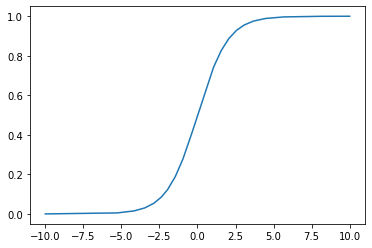

In [12]:
plt.plot(x, y);

In [13]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [14]:
t1 =log_softmax(pred); t1

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [15]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [16]:
t2 = log_softmax(pred); t2

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

### LogSumExp

To avoid numerical intsabilities, over/underflows, we use the following equality

$$\log\left(\sum_{j=1}^ne^{x_j}\right) = \log\left( e^{s}\sum_j e^{x_j - s}\right) = s + \log\left(\sum_j e^{x_j - s}\right)$$

Where $s = max_i(x_i)$

In [17]:
s = pred.max(-1)[0]

In [18]:
x.shape, s[:, None].shape

(torch.Size([200]), torch.Size([50000, 1]))

In [19]:
(x - s[:, None]).shape

torch.Size([50000, 200])

In [20]:
(s + (x - s[:, None]).exp().sum(-1).log()).shape

torch.Size([50000])

In [26]:
def logsumexp(x):
    s = x.max(-1)[0]
    return (s + (x - s[:, None]).exp().sum(-1).log()).unsqueeze(-1)

In [27]:
def log_softmax(x): return x - logsumexp(x)

In [28]:
pred.shape, logsumexp(pred).shape

(torch.Size([50000, 10]), torch.Size([50000, 1]))

In [29]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [30]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [31]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [32]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [33]:
sm_pred[range(3), y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

## Cross-Entropy Loss

From above, to get a maximum likelihood estimator we can simpyl average the logs of the probabilities. Using the $\text{softmax}$, we'll train our network to output probabilities, so we can define our loss as:

In [34]:
def cross_entropy_loss(x, target):
    return -x[range(target.shape[0]), target].mean()

In [35]:
loss = cross_entropy_loss(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [36]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In pytorch we can use `F.cross_entropy` directly

In [37]:
test_close(F.cross_entropy(pred, y_train), loss)

# Training Loop

In [38]:
loss_func = F.cross_entropy

In [39]:
bs = 50

xb = x_train[0:bs] # minibatch
preds = model(xb)
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [40]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [41]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [42]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [43]:
#| export
def accuracy(out, yb): return (out.argmax(dim=1) == yb).float().mean()

In [44]:
accuracy(preds, yb)

tensor(0.08)

In [45]:
lr = 0.5 
epochs = 3

In [46]:
#| export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [47]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


## Training loop

In [48]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
                
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


## Use parameters and optim

In [49]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [50]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [51]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [52]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [53]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [54]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [55]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [56]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [57]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()

            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
                
        report(loss, preds, yb)
        

In [58]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [59]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [60]:
mdl = MyModule(m, nh, 10)
mdl

In [61]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


# Register Modules

We can keep the modules in a list, but then have to manually register them

In [62]:
from functools import reduce

In [63]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [64]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

In [65]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [66]:
model(xb).shape

torch.Size([50, 10])

## nn.ModuleList

In [67]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [68]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [69]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


## nn.Sequential

In [70]:
model = nn.Sequential(
    nn.Linear(m, nh),
    nn.ReLU(),
    nn.Linear(nh, 10)    
)

In [71]:
fit()

0.16, 0.94
0.13, 0.96
0.08, 0.96


In [72]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [73]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [74]:
from IPython.core.debugger import set_trace

In [75]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: 
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [76]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [77]:
opt = Optimizer(model.parameters())

In [78]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


Pytorch already has the module `optim.SGD` for this

In [79]:
from torch import optim

In [80]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [81]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [82]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i + bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


## Dataset & Dataloader

### Dataset
Let's avoid having to constantly chop the data ourselves

In [83]:
#| export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [84]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [85]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)

In [86]:
model, opt = get_model()

In [87]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(n, i + bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


### Dataloader

Let's make an iteradle that gives us the the minbatechs directly

In [88]:
class Dataloader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [89]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [90]:
xb, yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [91]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

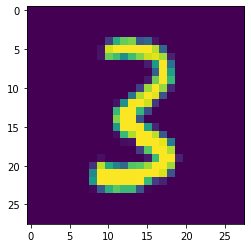

In [92]:
plt.imshow(xb[0].view(28, 28));
yb[0]

In [93]:
model, opt = get_model()

In [94]:
def fit(epochs=3):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [95]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.98
0.09, 0.98
0.06, 1.00


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

## Random sampling

Let's ensure that our training set is randomly ordered every iteration. This should not be the case for our validation set

In [120]:
from itertools import islice

def chunked(it, chunk_sz=1): 
    return iter(lambda: list(islice(it, chunk_sz)), [])

In [121]:
import random 

class Sampler():
    """
    Returns an iterator of indices for the given dataset. 
    These can possibly be shuffled
    """
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [122]:
ss = Sampler(train_ds)
it = iter(ss)

In [123]:
ss = Sampler(train_ds, shuffle=False)
list(islice(ss, 10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [124]:
sr = Sampler(train_ds, shuffle=True)
list(islice(sr, 10))

[23306, 15791, 18685, 21551, 22961, 11112, 42778, 41672, 48385, 20415]

In [125]:
class BatchSampler():
    """
    Given a sampler and a batch size, returns an iterator of indices 
    of the given batch size
    """
    def __init__(self, sampler, bs): self.sampler, self.bs = sampler, bs
    def __iter__(self): yield from chunked(iter(self.sampler), chunk_sz=self.bs)

In [128]:
batchs = BatchSampler(ss, 5)
list(islice(batchs, 5))

[[0, 1, 2, 3, 4],
 [5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [129]:
batchs = BatchSampler(sr, 5)
list(islice(batchs, 5))

[[34858, 44380, 43578, 7694, 8122],
 [2276, 46032, 35959, 25900, 12769],
 [22783, 13521, 42260, 40459, 5947],
 [35760, 8040, 20511, 2669, 7015],
 [19547, 19415, 31260, 19602, 41029]]

In [130]:
def collate(b):
    """
    Given a batch of pairs (x,y), stack them together
    x*, y*
    """
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [131]:
class Dataloader():
    """
    Return a collated iterator that's been batch sampled accordingly
    """
    def __init__(self, ds, batchs, collate_fn=collate):
        self.ds, self.batchs, self.collate_fn = ds, batchs, collate_fn
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)
        

In [132]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [133]:
train_dl = Dataloader(train_ds, batchs=train_samp)
valid_dl = Dataloader(valid_ds, batchs=valid_samp)

tensor(3)

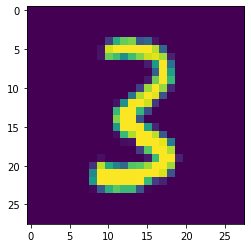

In [136]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28));
yb[0]

In [137]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

## Multiprocessing Dataloader

In [138]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [139]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [140]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [141]:
for o in map(train_ds.__getitem__, ([3,6], [8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [149]:
class Dataloader():
    """
    Creates a dataloader distributed along different processes
    """
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: 
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))
                     

In [150]:
dl = Dataloader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [152]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

## Pytorch DataLoader

In [153]:
#| export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [155]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [156]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [157]:
model, opt = get_model()
fit()

0.11, 0.94
0.07, 0.98
0.04, 0.98


In [158]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.14, grad_fn=<NllLossBackward0>), tensor(0.92))

Pytorch can auto-create the sequentila/random samplers

In [159]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [160]:
model, opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.13, 0.94
0.07, 0.96
0.19, 0.94


(tensor(0.09, grad_fn=<NllLossBackward0>), tensor(0.96))

In [161]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

In [163]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [164]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

Call `model.train()` before training, and `model.eval()` before inference as there are certain layers such as `nn.Dropout` and `nn.BatchNorm2d` that behave differently depending on training or inference

In [166]:
from tqdm.notebook import tqdm, trange

In [3]:
#| export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in trange(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [191]:
#| export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [192]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

In [193]:
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

0 0.15353523379191755 0.9556000047922134
1 0.11415097464807332 0.9655000042915344
2 0.11587181014940143 0.9667000061273575
3 0.11414644016884268 0.9658000040054321
4 0.10954055359703489 0.9703000056743621
CPU times: user 2min 41s, sys: 773 ms, total: 2min 42s
Wall time: 27.4 s


In [9]:
!pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 15.5 MB/s eta 0:00:00


In [36]:
import nbdev; nbdev.nbdev_export()